**Installing Necessary Libraries**

In [1]:
!pip install sentence-transformers scikit-learn pandas numpy

**Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

Stopwords removing Toggle

In [20]:
REMOVE_STOPWORDS = True

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

STOPWORDS = set(stopwords.words("english"))

def remove_stopwords(text):
    if not isinstance(text, str):
        return text
    return " ".join(t for t in text.split() if t.lower() not in STOPWORDS)

Implementing Basic Text Normalization : Creating the preprocessing function

In [21]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # lowercase
    text = text.lower()

    # removing special characters and punctuation (keep letters, numbers, spaces)
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # removing extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [22]:
df = pd.read_csv("fake_news_dataset.csv")

# Filling null values
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

**Mapping Labels**

In [23]:
# Remove leading/trailing spaces and convert to lowercase
df['label'] = df['label'].str.strip().str.lower()

# Map to integers
df['label'] = df['label'].map({'real': 0, 'fake': 1})

# Drop rows that didn’t match 'real' or 'fake'
df = df[df['label'].notnull()]

# Convert to int
df['label'] = df['label'].astype(int)

# Safety check
assert df['label'].isnull().sum() == 0
print("Rows left after label processing:", len(df))


Rows left after label processing: 20000


In [24]:
df['content'] = df['title'] + " " + df['text']

In [25]:
df["content"] = df["content"].apply(clean_text)
if REMOVE_STOPWORDS:
    df["content"] = df["content"].apply(remove_stopwords)

**Loading Model for text processing**

In [26]:
model = SentenceTransformer('all-MiniLM-L6-v2')

X = model.encode(
    df['content'].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

**Setting y**

In [27]:
y = df['label'].values

**Train-Test Split**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Using Logistic Regression for classification**

In [29]:
clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [30]:
# GridSearch using existing classifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear",
        random_state=42
    ),
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# REQUIRED OUTPUT
print("Best parameters:", grid_search.best_params_)

# overwrite clf with tuned model
clf = grid_search.best_estimator_


Best parameters: {'C': 1, 'penalty': 'l1'}


**Evaluation**

In [31]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4925
F1 Score: 0.48969331322272497

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.50      0.50      1989
           1       0.50      0.48      0.49      2011

    accuracy                           0.49      4000
   macro avg       0.49      0.49      0.49      4000
weighted avg       0.49      0.49      0.49      4000



Adjusting Classification Threshold and Visualizing Precision-Recall

In [33]:
# Get probabilities for the positive class ("Fake")
probs = clf.predict_proba(X_test)[:, 1]


In [34]:
def predict_with_threshold(probs, threshold=0.5):
    """
    Convert predicted probabilities into class labels based on a custom threshold.

    Args:
        probs (array-like): Probabilities of the positive class
        threshold (float): Threshold for labeling as positive

    Returns:
        numpy array of 0/1 predictions
    """
    return (probs > threshold).astype(int)


In [35]:
# Predict with a stricter threshold
y_pred_custom = predict_with_threshold(probs, threshold=0.5)


In [36]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Example for threshold=0.5
threshold = 0.5
y_pred_custom = predict_with_threshold(probs, threshold)

print(f"Metrics at threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom))
print("Recall:", recall_score(y_test, y_pred_custom))
print("F1-Score:", f1_score(y_test, y_pred_custom))


Metrics at threshold 0.5:
Accuracy: 0.4925
Precision: 0.49517031011692936
Recall: 0.48433615116857287
F1-Score: 0.48969331322272497


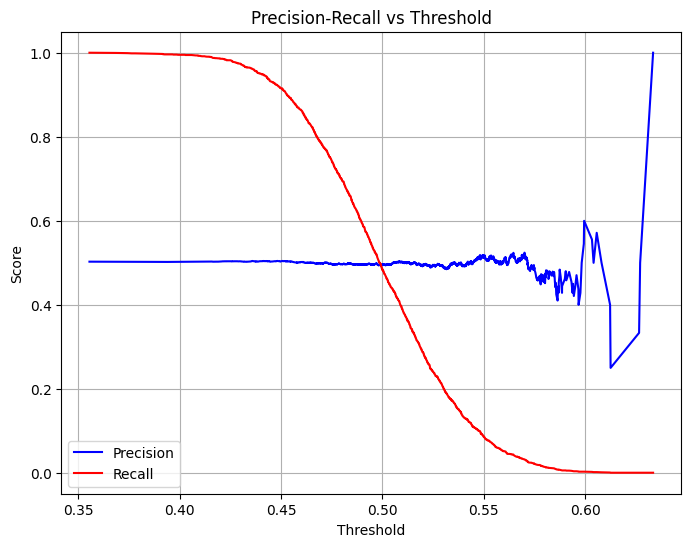

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


The Precision-Recall vs Threshold curve shows how the model's precision (blue line) and recall (red line) change as we vary the threshold for labeling a news article as "Fake."  

- **Precision**: The proportion of articles labeled "Fake" that are actually fake.  
- **Recall**: The proportion of actual fake articles that are correctly identified.  

By adjusting the threshold, we can make the model more **conservative** (high threshold → fewer false positives) or more **sensitive** (low threshold → fewer false negatives).  

For example, setting the threshold to 0.8 increases precision but may reduce recall, meaning the model labels fewer articles as "Fake," but those it does label are more likely to be truly fake.


In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [44]:
# Make predictions
y_pred = rf_clf.predict(X_test)

# Accuracy and F1-score
rf_accuracy = accuracy_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred, average="weighted")

# Precision and Recall
rf_precision = precision_score(y_test, y_pred, average="weighted")
rf_recall = recall_score(y_test, y_pred, average="weighted")

# Print all metrics
print("Random Forest Metrics")
print("-" * 30)
print(f"Accuracy : {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall   : {rf_recall:.4f}")
print(f"F1-Score : {rf_f1:.4f}")

Random Forest Metrics
------------------------------
Accuracy : 0.4890
Precision: 0.4890
Recall   : 0.4890
F1-Score : 0.4890


Comparison of the Accuracy and F1-score against the Logistic Regression baseline.



In [48]:
print("Model Comparison (Accuracy & F1-score)")
print("-" * 50)
print(f"Logistic Regression | Accuracy: {model_metrics['Logistic Regression']['Accuracy']:.4f} | F1-score: {model_metrics['Logistic Regression']['F1-Score']:.4f}")
print(f"Random Forest       | Accuracy: {model_metrics['Random Forest']['Accuracy']:.4f} | F1-score: {model_metrics['Random Forest']['F1-Score']:.4f}")


Model Comparison (Accuracy & F1-score)
--------------------------------------------------
Logistic Regression | Accuracy: 0.5133 | F1-score: 0.5156
Random Forest       | Accuracy: 0.4890 | F1-score: 0.4890


Multi-Model Comparison Table

In [46]:
# Dictionary to store model evaluation metrics
# Anyone who runs a model should add its metrics here.
# Format:
# model_metrics['Model Name'] = {
#     "Accuracy": ...,
#     "Precision": ...,
#     "Recall": ...,
#     "F1-Score": ...
# }

model_metrics = {}

model_metrics['Logistic Regression'] = {
    "Accuracy": 0.513265798359865,
    "Precision": 0.51,  # Weighted average from classification report
    "Recall": 0.51,     # Weighted average from classification report
    "F1-Score": 0.5156024963994239
}

# Random Forest metrics
model_metrics['Random Forest'] = {
    "Accuracy": rf_accuracy,
    "Precision": rf_precision,
    "Recall": rf_recall,
    "F1-Score": rf_f1
}

for model_name in model_metrics:
    model_metrics[model_name]["Stopword Removal"] = REMOVE_STOPWORDS

print(model_metrics)

{'Logistic Regression': {'Accuracy': 0.513265798359865, 'Precision': 0.51, 'Recall': 0.51, 'F1-Score': 0.5156024963994239, 'Stopword Removal': True}, 'Random Forest': {'Accuracy': 0.489, 'Precision': 0.488955348735306, 'Recall': 0.489, 'F1-Score': 0.4889501690785743, 'Stopword Removal': True}}


In [47]:
#Summary Table

metrics_df = pd.DataFrame(model_metrics).T.reset_index().rename(columns={"index": "Model Name"})
print(metrics_df)

            Model Name  Accuracy Precision Recall  F1-Score Stopword Removal
0  Logistic Regression  0.513266      0.51   0.51  0.515602             True
1        Random Forest     0.489  0.488955  0.489   0.48895             True


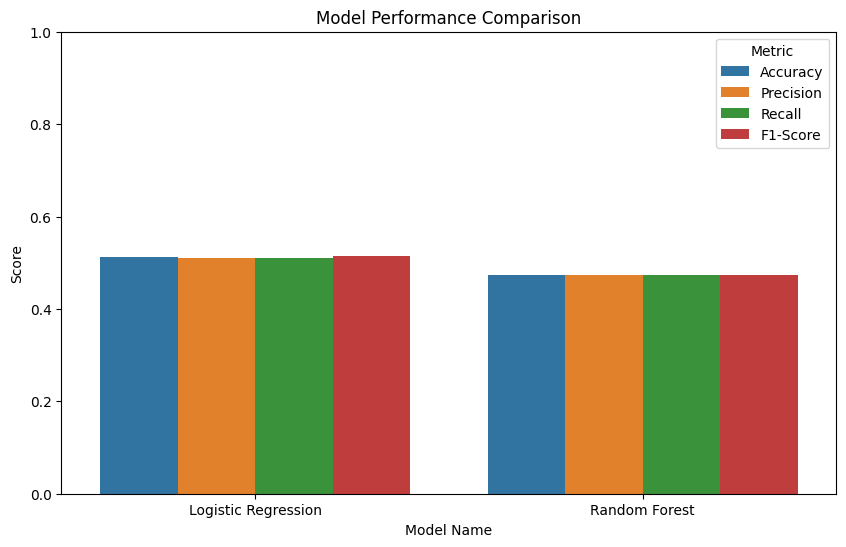

In [ ]:
plt.figure(figsize=(10,6))
metrics_plot = metrics_df.melt(id_vars='Model Name', var_name='Metric', value_name='Score')
sns.barplot(data=metrics_plot, x='Model Name', y='Score', hue='Metric')
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.show()